In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from Evaluation import get_metrics
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

---
## Read Data

In [2]:
from Data_prep import leave_last_out

In [3]:
path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '../'

In [4]:
data_path = 'Data/Amazon/'
# file_name = 'am_20k_users'
file_name = 'am_like_ml'

# data_path = 'Data/ML/'
# file_name = 'ml_1m'

In [5]:
df = pd.read_pickle(path + data_path + file_name)
total_items = df.item_id.nunique()
total_users = df.user_id.nunique()

In [6]:
# CFRNN Data
train_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_train_cfrnn')
val_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_val_cfrnn')
test_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_test_cfrnn')

# MF based Data
train_set_mf = pd.read_pickle(path + data_path + file_name + '_train_mf')
val_set_mf = pd.read_pickle(path + data_path + file_name + '_val_mf')
test_set_mf = pd.read_pickle(path + data_path + file_name + '_test_mf')

In [7]:
# Eval
steps = 5
rank_at = 20

---
# BPR

In [32]:
bpr_params = {
"nolf": 8, #Size of latent feature vectors
"n_iterations": 40, #around 20 is sufficient
"sample_size": 0.5*len(train_set_mf),
"seed": 1234,
"alpha": 0.08, # Learning rate: Amazon_01 best: 0.08
"rho": 1.1, # Bold driver increase alpha
"sigma": 0.5, # Bold driver decrease alpha
          
"reg_user": 0.1, # Am_40k best: 0.1 # ML_1 best: 0
"reg_item": 0.1, # Am_40k best: 0.1 # ML_1 best: 0
}

### Specify Param Changes

In [33]:
data_paths = ['Data/Amazon/']#['Data/ML/', 'Data/Amazon/', 'Data/Amazon/']
file_names = ['am_like_ml']#['ml_1m', 'am_like_ml', 'am_20k_users']
n_iterations = [25]
regs = [0, 0.0001, 0.001, 0.01, 0.1]
nolfs = [8]
sample_percs = [0.1, 0.3, 0.5, 0.8]
alphas = [0.03, 0.05, 0.08, 0.1, 0.12, 0.15]

all_runs = len(file_names) * len(n_iterations) * len(regs) * len(nolfs) * len(sample_percs) * len(alphas)
all_runs

120

## BPR Grid Search

In [34]:
from BPR import BPR
from Evaluation import get_metrics
runs = 0
for file_name, data_path in zip(file_names, data_paths):
    df = pd.read_pickle(path + data_path + file_name)
    total_items = df.item_id.nunique()
    total_users = df.user_id.nunique()

    # MF based Data
    train_set_mf = pd.read_pickle(path + data_path + file_name + '_train_mf')
    val_set_mf = pd.read_pickle(path + data_path + file_name + '_val_mf')
    test_set_mf = pd.read_pickle(path + data_path + file_name + '_test_mf')
    
    for n_iters in n_iterations:
        bpr_params['n_iterations'] = n_iters
        
        for reg in regs:
            bpr_params['reg_user'] = reg
            bpr_params['reg_item'] = reg
            
            for nolf in nolfs:
                bpr_params['nolf'] = nolf
                
                for alpha in alphas:
                    bpr_params['alpha'] = alpha
                    
                    for sample_perc in sample_percs:
                        runs += 1
                        print('\n', '='*60, '\n', 'Run:', runs, '/', all_runs)
#                         print('File:\t\t\t', file_name)
#                         print('Iterations:\t\t', n_iters)
#                         print('Regularisation:\t\t', reg)
#                         print('NOLF:\t\t\t', nolf)
#                         print('Learning Rate:\t\t', alpha)
#                         print('Sample Percentage:\t', sample_perc)
                        
                        bpr_params['sample_size'] = sample_perc * len(train_set_mf)
                        
                        samples_name = file_name + '_bpr_samples_' + str(sample_perc)
                        bpr = BPR(total_users, total_items, bpr_params)
                        bpr.train_model(
                        sample_path = path + data_path + 'Samples/' + samples_name + '.npy', 
                        train_set=train_set_mf, 
                        val_set=val_set_mf,
                        verbose=0,
                        patience=10,
                        save_best=True)
                        
                        ranked_df_bpr = bpr.get_predictions(train_set_mf, test_set_mf, stats=False)
                        bpr_metrics = get_metrics(ranked_df_bpr, steps, rank_at, stats=False)
                        bpr.model['total_test_rec'] = bpr_metrics.recall.sum()
                        bpr.model['test_rec@10'] = bpr_metrics.recall.iloc[2]
                        
                        ranked_df_val_bpr = bpr.get_predictions(train_set_mf, val_set_mf, stats=False)
                        bpr_val_metrics = get_metrics(ranked_df_val_bpr, steps, rank_at, stats=False)
                        bpr.model['total_val_rec'] = bpr_val_metrics.recall.sum()
                        bpr.model['val_rec@10'] = bpr_val_metrics.recall.iloc[2]
                        
                        bpr.store_model(path + '/Logs/GS/', file_name +  '_bpr_gs_log', gs=True)
                        


 Run: 1 / 120
Training BPR on 25 samples of size 17739
new results created

 Run: 2 / 120
Training BPR on 25 samples of size 53219
results added

 Run: 3 / 120
Training BPR on 25 samples of size 88699
results added

 Run: 4 / 120
Training BPR on 25 samples of size 141918
Early Stopping, no improvement for 10 iterations at iteration 23
results added

 Run: 5 / 120
Training BPR on 25 samples of size 17739
results added

 Run: 6 / 120
Training BPR on 25 samples of size 53219
Early Stopping, no improvement for 10 iterations at iteration 22
results added

 Run: 7 / 120
Training BPR on 25 samples of size 88699
results added

 Run: 8 / 120
Training BPR on 25 samples of size 141918
Early Stopping, no improvement for 10 iterations at iteration 15
results added

 Run: 9 / 120
Training BPR on 25 samples of size 17739
results added

 Run: 10 / 120
Training BPR on 25 samples of size 53219
Early Stopping, no improvement for 10 iterations at iteration 19
results added

 Run: 11 / 120
Training BPR on

In [17]:
file_names

['ml_1m', 'am_like_ml', 'am_20k_users']

In [35]:
pd.read_pickle(path + '/Logs/GS/' + file_names[0] +  '_bpr_gs_log').sort_values('sample_size', ascending=False).iloc[:10]

,all_val_rec@10,learning_rate,train_loss,val_auc,p,q,train_time,total_test_rec,test_rec@10,total_val_rec,val_rec@10,nolf,n_iterations,sample_size,seed,alpha,rho,sigma,reg_user,reg_item
119,"[0.052, 0.064, 0.068, 0.064, 0.068, 0.074, 0.0...","[0.15, 0.165, 0.18150000000000002, 0.199650000...","[0.7043881976962948, 0.6889173128061397, 0.683...",[],0,0,134.801248,0.263,0.060,0.286,0.066,8,25,141918.4,1234,0.15,1.1,0.5,0.1,0.1
23,"[0.056, 0.062, 0.064, 0.066, 0.064, 0.064, 0.0...","[0.15, 0.165, 0.18150000000000002, 0.199650000...","[0.6608883494615949, 0.6050789598609118, 0.574...",[],0,0,124.241992,0.179,0.042,0.206,0.050,8,25,141918.4,1234,0.15,1.1,0.5,0,0
31,"[0.012, 0.054, 0.056, 0.062, 0.062, 0.068, 0.0...","[0.05, 0.05500000000000001, 0.0605000000000000...","[0.6920082776830875, 0.6681795288902694, 0.633...",[],0,0,134.628349,0.270,0.059,0.310,0.066,8,25,141918.4,1234,0.05,1.1,0.5,0.0001,0.0001
111,"[0.04, 0.058, 0.066, 0.064, 0.068, 0.07, 0.068...","[0.1, 0.11000000000000001, 0.12100000000000002...","[0.7064038531794756, 0.6960554797868959, 0.686...",[],0,0,168.596925,0.252,0.058,0.288,0.070,8,25,141918.4,1234,0.10,1.1,0.5,0.1,0.1
35,"[0.052, 0.052, 0.062, 0.064, 0.066, 0.068, 0.0...","[0.08, 0.08800000000000001, 0.0968000000000000...","[0.6858610809888775, 0.6362789368974017, 0.612...",[],0,0,168.433234,0.158,0.039,0.176,0.044,8,25,141918.4,1234,0.08,1.1,0.5,0.0001,0.0001
39,"[0.054, 0.058, 0.064, 0.066, 0.066, 0.066, 0.0...","[0.1, 0.11000000000000001, 0.12100000000000002...","[0.6775586583155652, 0.6260989703920962, 0.599...",[],0,0,143.225331,0.164,0.040,0.192,0.048,8,25,141918.4,1234,0.10,1.1,0.5,0.0001,0.0001
43,"[0.054, 0.06, 0.064, 0.066, 0.066, 0.064, 0.06...","[0.12, 0.132, 0.14520000000000002, 0.159720000...","[0.6699955793277058, 0.6173297044446853, 0.589...",[],0,0,143.685142,0.159,0.039,0.176,0.042,8,25,141918.4,1234,0.12,1.1,0.5,0.0001,0.0001
47,"[0.056, 0.062, 0.064, 0.066, 0.064, 0.064, 0.0...","[0.15, 0.165, 0.18150000000000002, 0.199650000...","[0.6610038544442468, 0.6053765355005344, 0.574...",[],0,0,151.575748,0.134,0.034,0.162,0.042,8,25,141918.4,1234,0.15,1.1,0.5,0.0001,0.0001
51,"[0.0, 0.022, 0.054, 0.054, 0.06, 0.062, 0.062,...","[0.03, 0.033, 0.036300000000000006, 0.03993000...","[0.6929562009375422, 0.6900420315705108, 0.670...",[],0,0,193.639085,0.255,0.057,0.300,0.068,8,25,141918.4,1234,0.03,1.1,0.5,0.001,0.001
55,"[0.012, 0.054, 0.058, 0.062, 0.062, 0.068, 0.0...","[0.05, 0.05500000000000001, 0.0605000000000000...","[0.6921786987049776, 0.6689905470891462, 0.635...",[],0,0,168.581663,0.222,0.053,0.236,0.056,8,25,141918.4,1234,0.05,1.1,0.5,0.001,0.001


---
# CFRNN

In [19]:
cfrnn_params = {
'train_time':0,
'epochs':20,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.01,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
'ckpt_dir': path + 'Logs/GS/ckpts/cfrnn_ckpts_' + file_name + '/ckpts_{epoch:02d}',

'test_users': 500,
'val_users': 500,

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

### Specify Param Changes

In [21]:
data_paths = ['Data/ML/', 'Data/Amazon/', 'Data/Amazon/']
file_names = ['ml_1m', 'am_like_ml', 'am_20k_users']
n_epochs = [20, 100, 200]
batch_sizes = [16, 32, 64]
alphas = [0.05, 0.1, 0.2]
max_seq_lens = [10, 20, 30]
embedding_dims = [100]
all_rnn_units = [20, 50]

all_runs = len(file_names) * len(n_epochs) * len(batch_sizes) * len(alphas) * len(max_seq_lens) * len(embedding_dims) * len(all_rnn_units)
all_runs

486

## BPR Grid Search

In [23]:
file_name

'ml_1m'

In [25]:
from CFRNN import CFRNN
runs = 0
for file_name, data_path in zip(file_names, data_paths):
    df = pd.read_pickle(path + data_path + file_name)
    total_items = df.item_id.nunique()
    total_users = df.user_id.nunique()
    
    cfrnn = CFRNN(total_users, total_items, cfrnn_params)
    cfrnn.build_model(summary=False)
    cfrnn.compile_model(train_set=train_set_cfrnn)

   # CFRNN Data
    train_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_train_cfrnn')
    val_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_val_cfrnn')
    test_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_test_cfrnn')
    
    train_dataset = cfrnn.create_seq_batch_tf_dataset(train_set_cfrnn, stats=False)
    val_dataset = cfrnn.create_seq_batch_tf_dataset(val_set_cfrnn, stats=False)
    
    val_set, left_out_val = leave_last_out(val_set_cfrnn, n_items=1)
    test_set, left_out_test = leave_last_out(test_set_cfrnn, n_items=1)
    
    cfrnn_params['ckpt_dir'] = path + 'Logs/GS/ckpts/cfrnn_ckpts_' + file_name + '/ckpts_{epoch:02d}'

    for epochs in n_epochs:
        cfrnn_params['epochs'] = epochs
        
        for batch_size in batch_sizes:
            cfrnn_params['batch_sizes'] = batch_size
            
            for alpha in alphas:
                cfrnn_params['learning_rate'] = alpha
                
                for max_seq_len in max_seq_lens:
                    cfrnn_params['max_seq_len'] = max_seq_len
                    
                    for embedding_dim in embedding_dims:
                        cfrnn_params['embedding_dim'] = embedding_dim
                        
                        for rnn_units in all_rnn_units:
                            cfrnn_params['rnn_units'] = rnn_units
                            runs += 1
                            print('\n', '='*60, '\n', 'Run:', runs, '/', all_runs)
                            print('File:\t\t\t', file_name)
                            print('Epochs:\t\t\t', epochs)
                            print('Batch_size:\t\t', batch_size)
                            print('Learning Rate:\t\t', alpha)
                            print('Max Seq Len:\t\t', max_seq_len)
                            print('Embedding Dim:\t\t', embedding_dim)
                            print('RNN Units:\t\t', rnn_units)

                            cfrnn = CFRNN(total_users, total_items, cfrnn_params)
                            cfrnn.build_model(summary=False)
                            cfrnn.compile_model(train_set=train_set_cfrnn)
                            cfrnn.train(train_dataset, val_dataset, verbose=1)

                            val_rec_10 = []
                            
                            for e in range(10, epochs, 10):
                                ranked_df_cfrnn = cfrnn.get_predictions(val_set_cfrnn, val_set, left_out_val, batch_size=500, rank_at=rank_at, 
                                                                        ckpt_dir=f'/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/Logs/GS/ckpts/cfrnn_ckpts_{file_name}/ckpts_{e}')
                                cfrnn_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
                                print(cfrnn_metrics['recall'].iloc[2], cfrnn_metrics['recall'].sum())
                                print(cfrnn_metrics)
                                
                            ranked_df_cfrnn = cfrnn.get_predictions(test_set_cfrnn, test_set, left_out_test, batch_size=500, rank_at=rank_at, 
                                                                        ckpt_dir=f'/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/Logs/GS/ckpts/cfrnn_ckpts_{file_name}/ckpts_{e}')
                            cfrnn_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
                            print(cfrnn_metrics['recall'].iloc[2], cfrnn_metrics['recall'].sum())
                                

#                             bpr.store_model(path + '/Logs/GS/', file_name +  '_bpr_gs_log', file_name, gs=True)

Creating Diveristy Bias
Compiled LSTM

 Run: 1 / 486
File:			 ml_1m
Epochs:			 20
Batch_size:		 16
Learning Rate:		 0.05
Max Seq Len:		 10
Embedding Dim:		 100
RNN Units:		 20
Creating Diveristy Bias
Compiled LSTM
Fitting LSTM with parameters:
train_time                                                          0
epochs                                                             20
BATCH_SIZE                                                         32
learning_rate                                                    0.05
delta                                                            0.01
max_seq_len                                                        10
embedding_dim                                                     100
rnn_units                                                          20
ckpt_dir            /Users/Robin/Google Drive/Thesis (Msc)/Thesis_...
test_users                                                        500
val_users                                               

KeyboardInterrupt: 

In [45]:
from CFRNN import CFRNN
cfrnn = CFRNN(total_users, total_items, cfrnn_params)
cfrnn.build_model(summary=False)
cfrnn.compile_model(train_set=train_set_cfrnn)

Creating Diveristy Bias
Compiled LSTM


In [46]:
train_dataset = cfrnn.create_seq_batch_tf_dataset(train_set_cfrnn.iloc[:1000], stats=False)
val_dataset = cfrnn.create_seq_batch_tf_dataset(val_set_cfrnn, stats=False)

In [47]:
cfrnn.train(train_dataset, val_dataset, verbose=1)

Fitting LSTM with parameters:
train_time                                                          0
epochs                                                            100
BATCH_SIZE                                                         32
learning_rate                                                     0.1
delta                                                            0.01
max_seq_len                                                        30
embedding_dim                                                     100
rnn_units                                                          20
ckpt_dir            /Users/Robin/Google Drive/Thesis (Msc)/Thesis_...
test_users                                                        500
val_users                                                         500
pad_value                                                       87290
shift_targets_by                                                    1
Name: 0, dtype: object
Epoch 1/100
1/1 [====================

KeyboardInterrupt: 

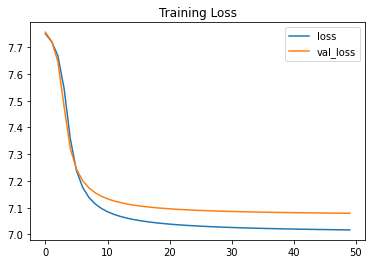

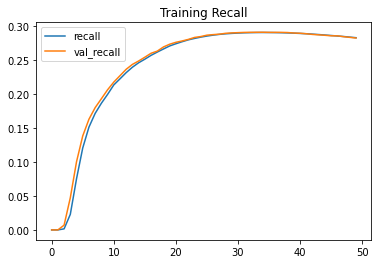

In [33]:
cfrnn.plot_training()

In [34]:
cfrnn_params['ckpt_dir']

'../Logs/ckpts/cfrnn_ckpts_ml_1m/ckpts'

In [48]:
cfrnn_params['ckpt_dir']

'/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/Logs/GS/ckpts/cfrnn_ckpts_am_like_ml/ckpts_{epoch:02d}'

In [52]:
test_set, left_out = leave_last_out(test_set_cfrnn, n_items=1)

for e in range(10, 30, 10):
    ranked_df_cfrnn = cfrnn.get_predictions(train_set_cfrnn, test_set, left_out, batch_size=500, rank_at=rank_at, ckpt_dir=f'/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/Logs/GS/ckpts/cfrnn_ckpts_am_like_ml/ckpts_{e}')
    cfrnn_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
    print(cfrnn_metrics['recall'].iloc[2], cfrnn_metrics['recall'].sum())

0.041 0.171
0.037 0.15400000000000003


In [36]:
cfrnn_metrics.to_pickle(path + 'Results/CFRNN/' + file_name + '_metrics')

---
# NCF

In [23]:
GMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'nolf': 8,
    'regs': [0.000001,0.000001],
    'epochs': 10,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'weights_dir': f'../Logs/weights/GMF_weights_{file_name}/GMF_weights',
    'optimizer':'Adam'
}

MLP_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0.00001,0.00001,0.00001,0.00001],   #ML: [+-0.0005,0,0,0],
    'epochs': 10,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 10,
    'weights_dir': f'../Logs/weights/MLP_weights_{file_name}/MLP_weights',
    'optimizer':'Adam'
}

NeuMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0.00001,0.00001,0.00001,0.00001],#[0.0001, 0.0001, 0.0001, 0.0001],
    'reg_mf': [0.000001,0.000001],
    'nolf': 8,
    'epochs': 25,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'weights_dir': f'../Logs/weights/NeuMF_weights_{file_name}/NeuMF_weights',
    'optimizer':'Adam'
}

In [24]:
from NCF import NCF
NCF = NCF(total_users, total_items, GMF_params, MLP_params, NeuMF_params)
NCF.build_GMF_model()
NCF.build_MLP_model()
NCF.build_NeuMF_model()

In [21]:
sample_path = path + data_path + 'Samples/' + file_name + '_samples_4_neg/'
samples = NCF.load_samples(sample_path, file_name + '_sample', 25)

100% |########################################################################|


In [22]:
GMF_val_metrics = NCF.train_model('GMF', samples)


Fitting GMF with parameters:
learning_rate                                               0.0005
batch_size                                                     256
nolf                                                             8
regs                                                [1e-06, 1e-06]
epochs                                                          10
sample_size                                                 176012
num_neg                                                          4
weights_dir      ../Logs/weights/GMF_weights_am_like_ml/GMF_wei...
optimizer                                                     Adam
Name: 0, dtype: object
Epoch: 0
Train on 880060 samples


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


880060/880060 [==============================] - 15s 17us/sample - loss: 0.5449
Epoch: 1
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.3761
Epoch: 2
Train on 880060 samples
880060/880060 [==============================] - 15s 16us/sample - loss: 0.2331
Epoch: 3
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.1449
Epoch: 4
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.1038
Epoch: 5
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.0825
Epoch: 6
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.0696
Epoch: 7
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.0607
Epoch: 8
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.0541
Epoch: 9
Train o

In [25]:
MLP_val_metrics = NCF.train_model('MLP', samples)


Fitting MLP with parameters:
learning_rate                                               0.0005
batch_size                                                     256
layers                                             [16, 32, 16, 8]
reg_layers                            [1e-05, 1e-05, 1e-05, 1e-05]
epochs                                                          10
sample_size                                                 176012
num_neg                                                         10
weights_dir      ../Logs/weights/MLP_weights_am_like_ml/MLP_wei...
optimizer                                                     Adam
Name: 0, dtype: object
Epoch: 0
Train on 880060 samples


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


880060/880060 [==============================] - 17s 19us/sample - loss: 0.3631
Epoch: 1
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2922
Epoch: 2
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2802
Epoch: 3
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2617
Epoch: 4
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2223
Epoch: 5
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1792
Epoch: 6
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1460
Epoch: 7
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1222
Epoch: 8
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1055
Epoch: 9
Train o

In [26]:
NCF.use_pretrain_model()
NCF.NeuMF_params['optimizer'] = 'SGD'

In [ ]:
NeuMF_val_metrics = NCF.train_model('NeuMF', samples, train_set=train_set_mf, val_set=val_set_mf)

In [39]:
ranked_df_neumf = NCF.get_predictions('NeuMF', train_set=train_set_mf, test_set=test_set_mf)
neumf_metrics = get_metrics(ranked_df_neumf, stats=False)
neumf_metrics

100% |########################################################################|


,rank_at,hitcounts,recall,precision,ndcg
0,1,0,0.0000,0.00000,0.000000
1,5,1,0.0005,0.00010,0.000215
2,10,2,0.0010,0.00010,0.000360
3,15,3,0.0015,0.00010,0.000499
4,20,6,0.0030,0.00015,0.000843


In [28]:
ranked_df_neumf = NCF.get_predictions('NeuMF', train_set=train_set_mf, test_set=test_set_mf)
neumf_metrics = get_metrics(ranked_df_neumf, stats=False)
neumf_metrics

100% |########################################################################|


,rank_at,hitcounts,recall,precision,ndcg
0,1,9,0.009,0.009000,0.009000
1,5,19,0.019,0.003800,0.013959
2,10,24,0.024,0.002400,0.015539
3,15,32,0.032,0.002133,0.017668
4,20,38,0.038,0.001900,0.019069


In [29]:
neumf_metrics.to_pickle(path + 'Results/NCF/' + file_name + '_metrics')

---
## Compare

In [52]:
# file_name = 'ml_1m'
file_name = 'am_20k_users'
# file_name = 'am_like_ml'

In [53]:
bpr_metrics = pd.read_pickle(path + 'Results/BPR/' + file_name + '_metrics')
neumf_metrics = pd.read_pickle(path + 'Results/NCF/' + file_name + '_metrics')
cfrnn_metrics = pd.read_pickle(path + 'Results/CFRNN/' + file_name + '_metrics')

In [54]:
store_path = path + 'Plots/' + file_name
plot_title = f'Comparison {file_name}'

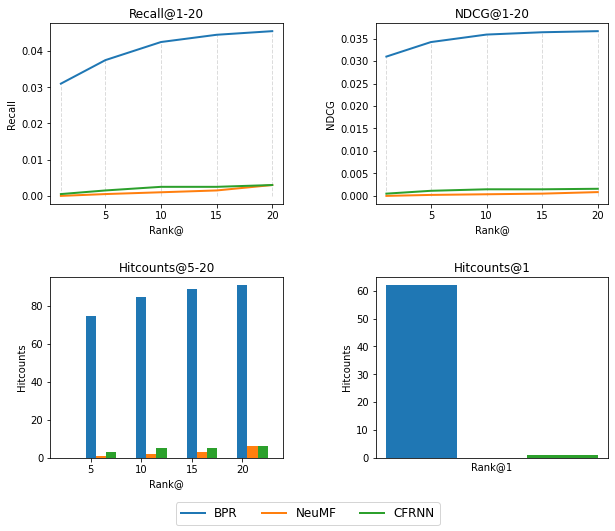

In [55]:
from visualize_results import plot_metrics
plot_metrics([bpr_metrics, neumf_metrics, cfrnn_metrics], ['BPR', 'NeuMF', 'CFRNN'], store_path=store_path)